# Validation of Price in Space

@roman

19 June, 2024

---
# Settings

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import uuid
import h3
import os

from INEGIpy import MarcoGeoestadistico

from sklearn.cluster import DBSCAN
from scipy.spatial import KDTree

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Settings
# show 100 columns in pandas
pd.set_option('display.max_columns', 100)
geo_framework = MarcoGeoestadistico()

---
# Data

## Properties

In [3]:
# read parquet
df_properties = pd.read_parquet("../../data/raw/appraisals.parquet")
print(df_properties.shape[0])
df_properties.head()

2339244


,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,property_account_id,special_common_installations_description,special_private_installations_description,complementary_common_works_description,age_in_months,parking_lots,valuation_date,common_areas_completion_percentage,private_works_completion_percentage,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,latitude,longitude,level,total_levels,purpose_of_appraisal,bedrooms,accessory_area,built_area,saleable_area,land_area,distance_to_public_transportation,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id
0,1,2,4,VISTA HERMOSA HUITEPEC,NO APLICA,29263,<NA>,<NA>,<NA>,<NA>,36,1,2022-06-14,NaN,100.0,NaN,NaN,NaN,NaN,4,4,301ef216-0137-4989-bdd0-32bf1adf1e9b,0.0,7,1,NaN,1,2,78,6f8c15c7-2914-40bb-87ff-59076af288c9,3,NaN,NaN,NaN,2,NaN,35a7806a-f686-4159-be91-16997e86d271,87aa63b6-9005-4ed3-ba44-fcd75453a9e9,16.737283,-92.672659,3,3,S/D,3,10.750000,216.809998,227.559998,302.700012,NaN,1.0,NaN,<NA>,3716737.0,3717000.0,2532281.13,1033417.8,<NA>,67,02086af7-ffbb-4e67-b857-27e6cef09b0d,2b225ce9-7742-512e-aac5-846811f1a6a1
1,1,2,4,MAYA,NO APLICA,97134,<NA>,<NA>,<NA>,<NA>,204,1,2022-11-15,NaN,100.0,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,50,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,21.014297,-89.575189,3,2,S/D,3,13.380000,141.550003,154.929993,198.000000,NaN,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.0,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52
2,0,1,3,KANASIN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,60,1,2022-06-22,NaN,100.0,NaN,NaN,NaN,NaN,3,5,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,41,98013144-6a9f-4e08-9255-cb54568d2f5a,2,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,a7f6ef17-0933-4138-9aa9-99529929184d,20.928954,-89.546637,3,1,S/D,2,1.120000,44.349998,45.470001,144.800003,NaN,1.0,NaN,<NA>,446378.0,450000.0,279611.30,102663.2,<NA>,55,e57ad294-8db8-4ca1-b01f-7ccbc5981922,552216f4-540b-500d-a4e7-6be55b2b6703
3,0,1,3,MULCHECHEN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,192,1,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,41,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,20.916897,-89.580945,3,1,S/D,2,2.160000,52.049999,54.209999,133.750000,NaN,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.0,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54
4,0,3,4,POBLACION MOTUL,NO APLICA,97430,<NA>,<NA>,<NA>,<NA>,116,0,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,4,4,1f637d21-f0cb-43be-b989-5923e4c01d94,0.0,31,1,NaN,1,2,52,bc0e00ba-8c35-465f-bbcd-61cedf83d6d8,1,NaN,NaN,NaN,2,NaN,90a0a9f7-fab3-4170-b3da-db49e122e41b,f6e764a4-141c-4b02-b902-4a158ec58c58,21.096391,-89.285366,3,2,S/D,2,19.049999,229.929993,248.979996,844.520020,NaN,1.0,NaN,<NA>,2779000.0,2779000.0,1767043.79,641835.2,<NA>,39,74af41d9-b7b3-464d-9302-7fd1f231ee26,5b18adfe-606c-590f-bc76-d3eabfd0ba41


In [4]:
# geodataframe
gdf_properties = (
    gpd.GeoDataFrame(
        df_properties,
        geometry=gpd.points_from_xy(df_properties['longitude'], df_properties['latitude']),
        crs='EPSG:4326'
    )
    .drop(columns=['latitude', 'longitude'])
    .assign(
        state_id=lambda x: x['state_id'].astype(str).str.zfill(2),
        municipality_id=lambda x: x['municipality_id'].astype(str).str.zfill(3)
    )
)

gdf_properties.head()

,half_bathrooms,full_bathrooms,property_class_more_common_in_area,neighborhood,constructor,zip_code,property_account_id,special_common_installations_description,special_private_installations_description,complementary_common_works_description,age_in_months,parking_lots,valuation_date,common_areas_completion_percentage,private_works_completion_percentage,potable_water_service_id,lighting_service_id,sidewalk_id,project_quality_id,property_class_id,conservation_status_id,controller_id,elevator_service_id,state_id,equipment_id,curb_id,infrastructure_service_id,road_materials_id,municipality_id,grantor_id,urban_proximity_id,water_collection_service_id,electrical_supply_service_id,telephone_service_supply_id,property_type_id,public_transportation_service_id,valuation_unit_id,valuation_professional_id,level,total_levels,purpose_of_appraisal,bedrooms,accessory_area,built_area,saleable_area,land_area,distance_to_public_transportation,rentable_units,rentable_units_subject_property,current_use,market_price,price,built_price,land_price,access_routes,remaining_useful_life,observation_id,property_id,geometry
0,1,2,4,VISTA HERMOSA HUITEPEC,NO APLICA,29263,<NA>,<NA>,<NA>,<NA>,36,1,2022-06-14,NaN,100.0,NaN,NaN,NaN,NaN,4,4,301ef216-0137-4989-bdd0-32bf1adf1e9b,0.0,07,1,NaN,1,2,078,6f8c15c7-2914-40bb-87ff-59076af288c9,3,NaN,NaN,NaN,2,NaN,35a7806a-f686-4159-be91-16997e86d271,87aa63b6-9005-4ed3-ba44-fcd75453a9e9,3,3,S/D,3,10.750000,216.809998,227.559998,302.700012,NaN,1.0,NaN,<NA>,3716737.0,3717000.0,2532281.13,1033417.8,<NA>,67,02086af7-ffbb-4e67-b857-27e6cef09b0d,2b225ce9-7742-512e-aac5-846811f1a6a1,POINT (-92.67266 16.73728)
1,1,2,4,MAYA,NO APLICA,97134,<NA>,<NA>,<NA>,<NA>,204,1,2022-11-15,NaN,100.0,NaN,NaN,NaN,NaN,4,4,717559f7-a918-48f7-9356-c79c582d95b3,0.0,31,2,NaN,1,2,050,9a2781c9-b312-453c-86d1-a6e90584a083,2,NaN,NaN,NaN,2,NaN,b3bf58b2-40cc-4edd-bcf1-e4a0b2798533,02af4710-0922-4bed-9763-045ba14e0283,3,2,S/D,3,13.380000,141.550003,154.929993,198.000000,NaN,1.0,NaN,<NA>,2348706.0,2349000.0,1111845.21,984852.0,<NA>,53,43c375b2-75fd-4fcc-b311-55b396e7cbbf,b7f8c282-b67e-5d63-920d-c603b4e2eb52,POINT (-89.57519 21.01430)
2,0,1,3,KANASIN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,60,1,2022-06-22,NaN,100.0,NaN,NaN,NaN,NaN,3,5,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,041,98013144-6a9f-4e08-9255-cb54568d2f5a,2,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,a7f6ef17-0933-4138-9aa9-99529929184d,3,1,S/D,2,1.120000,44.349998,45.470001,144.800003,NaN,1.0,NaN,<NA>,446378.0,450000.0,279611.30,102663.2,<NA>,55,e57ad294-8db8-4ca1-b01f-7ccbc5981922,552216f4-540b-500d-a4e7-6be55b2b6703,POINT (-89.54664 20.92895)
3,0,1,3,MULCHECHEN,NO APLICA,97370,<NA>,<NA>,<NA>,<NA>,192,1,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,3,4,8378ef1c-2fdf-4b2a-be29-0e62eb19d753,2.0,31,2,NaN,1,3,041,98013144-6a9f-4e08-9255-cb54568d2f5a,3,NaN,NaN,NaN,2,NaN,4e63856b-ae68-4653-bcaa-86a51d5d7053,923b9bb1-9ab4-4984-93f1-c873b3c26977,3,1,S/D,2,2.160000,52.049999,54.209999,133.750000,NaN,1.0,NaN,<NA>,424468.0,424000.0,290492.55,96835.0,<NA>,44,f95c14fe-9acc-4b5c-872b-bd15d412a65d,7215360d-9d5e-538a-971f-15fbef435f54,POINT (-89.58095 20.91690)
4,0,3,4,POBLACION MOTUL,NO APLICA,97430,<NA>,<NA>,<NA>,<NA>,116,0,2022-11-01,NaN,100.0,NaN,NaN,NaN,NaN,4,4,1f637d21-f0cb-43be-b989-5923e4c01d94,0.0,31,1,NaN,1,2,052,bc0e00ba-8c35-465f-bbcd-61cedf83d6d8,1,NaN,NaN,NaN,2,NaN,90a0a9f7-fab3-4170-b3da-db49e122e41b,f6e764a4-141c-4b02-b902-4a158ec58c58,3,2,S/D,2,19.049999,229.929993,248.979996,844.520020,NaN,1.0,NaN,<NA>,2779000.0,2779000.0,1767043.79,641835.2,<NA>,39,74af41d9-b7b3-464d-9302-7fd1f231ee26,5b18adfe-606c-590f-bc76-d3eabfd0ba41,POINT (-89.28537 21.09639)


In [5]:
# eliminate from memory
del df_properties

## Inegi

In [6]:
# get all mexico states
gdf_mex_states = geo_framework.Entidades()
gdf_mex_states.head()

,geometry,cvegeo,cve_agee,nom_agee,nom_abrev,pob,pob_fem,pob_mas,viv
0,"MULTIPOLYGON (((-102.29739 22.45527, -102.2955...",01,01,Aguascalientes,Ags.,1425607,728924,696683,386671
1,"MULTIPOLYGON (((-114.11561 28.09639, -114.1152...",02,02,Baja California,BC,3769020,1868431,1900589,1149563
2,"MULTIPOLYGON (((-109.89451 22.87476, -109.8946...",03,03,Baja California Sur,BCS,798447,392568,405879,240660
3,"MULTIPOLYGON (((-91.95650 20.19700, -91.95636 ...",04,04,Campeche,Camp.,928363,471424,456939,260824
4,"MULTIPOLYGON (((-102.31549 29.88000, -102.3150...",05,05,Coahuila de Zaragoza,Coah.,3146771,1583102,1563669,901249


<Axes: >

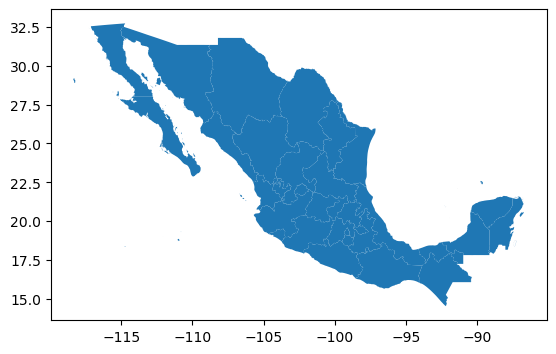

In [7]:
# plot states
gdf_mex_states.plot()

---
# Geographical Clustering

## S0: Get rid of generic coordinates

In [8]:
# eliminate generic coords
gdf_properties = (
    gdf_properties
    .drop_duplicates(subset=['geometry'])
)

# print
print(f"Number of properties: {gdf_properties.shape[0]}")

Number of properties: 2041081


## S1: Define minimum number of points to form a cluster

In [9]:
# from crs 4326 to 6372
gdf_properties = gdf_properties.to_crs('EPSG:6372')

# get lon and lat
gdf_properties['longitude'] = gdf_properties.geometry.x
gdf_properties['latitude'] = gdf_properties.geometry.y

In [10]:
# define function to get poiunts at r distance
def get_neighbors(gdf, r):
    # fit a kdtree
    kdtree = KDTree(
        data=gdf[['longitude', 'latitude']],
    )
    # count neighbors at r-km
    gdf[f'neighbors_{r}km'] = kdtree.query_ball_point(
        gdf[['longitude', 'latitude']],
        r=r * 1_000,
        workers=-1,
        return_length=True
    )
    return gdf

# get neighbors at provided distances
list_distances = [0.1, 0.25, 0.3, 0.4, 0.45, 0.5, 0.75, 1, 1.5, 2]

for r in tqdm(list_distances):
    gdf_properties = get_neighbors(gdf_properties, r)

100%|██████████| 10/10 [00:42<00:00,  4.24s/it]


In [21]:
# get percentil of neighbors at N
def percentil_at_x(x, p):
    return x.gt(p).mean()

# get percentil of neighbors at N
N_MIN_NEIGHBORS = 200

In [22]:
# General
(
    gdf_properties
    .filter(like='neighbors')
    .apply(
        lambda x: percentil_at_x(x, N_MIN_NEIGHBORS)
    )
    .sort_values()
)


neighbors_0.1km     0.056071
neighbors_0.25km    0.333047
neighbors_0.3km     0.383540
neighbors_0.4km     0.492826
neighbors_0.45km    0.545377
neighbors_0.5km     0.593216
neighbors_0.75km    0.764759
neighbors_1km       0.857871
neighbors_1.5km     0.929647
neighbors_2km       0.953346
dtype: float64

In [20]:
# look percentil at 30, 50, 75 and 100
for p in [20, 30, 50, 75, 100, 200, 300]:
    print(
        f"Percentil at {p} {'=' * 10} \n",
        (
            gdf_properties
            .filter(like='neighbors')
            .apply(
                lambda x: percentil_at_x(x, p)
            )
            .sort_values()
        )
    )

Percentil at 20 ========== 
 neighbors_0.1km     0.556545
neighbors_0.25km    0.861187
neighbors_0.3km     0.897548
neighbors_0.4km     0.938990
neighbors_0.45km    0.950740
neighbors_0.5km     0.958908
neighbors_0.75km    0.978093
neighbors_1km       0.984880
neighbors_1.5km     0.989884
neighbors_2km       0.991933
dtype: float64
Percentil at 30 ========== 
 neighbors_0.1km     0.469961
neighbors_0.25km    0.797386
neighbors_0.3km     0.845888
neighbors_0.4km     0.905245
neighbors_0.45km    0.923504
neighbors_0.5km     0.936866
neighbors_0.75km    0.968035
neighbors_1km       0.978608
neighbors_1.5km     0.986391
neighbors_2km       0.989232
dtype: float64
Percentil at 50 ========== 
 neighbors_0.1km     0.383466
neighbors_0.25km    0.686635
neighbors_0.3km     0.754139
neighbors_0.4km     0.840278
neighbors_0.45km    0.868941
neighbors_0.5km     0.890782
neighbors_0.75km    0.947407
neighbors_1km       0.966252
neighbors_1.5km     0.979533
neighbors_2km       0.984441
dtype: float6

In [24]:
# now see it at state level
(
    gdf_properties
    .groupby('state_id')
    .apply(
        lambda x: x.filter(like='neighbors').apply(
            lambda x: percentil_at_x(x, 100)
        )
    )
    .T
    .sort_index()
    .style.format("{:.0%}")
)

/var/folders/42/2lkg1sf91wv7mjxw6klfcqtc0000gn/T/ipykernel_30687/4151588856.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


state_id,01,02,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32
neighbors_0.1km,32%,11%,4%,0%,17%,11%,9%,11%,10%,15%,26%,11%,45%,23%,26%,19%,20%,18%,41%,6%,22%,29%,46%,16%,16%,15%,6%,24%,10%,15%,20%,29%
neighbors_0.25km,64%,26%,32%,14%,45%,41%,29%,48%,43%,42%,55%,29%,64%,54%,49%,38%,45%,46%,67%,14%,45%,64%,70%,45%,48%,42%,20%,46%,21%,34%,54%,48%
neighbors_0.3km,71%,30%,39%,17%,54%,51%,34%,58%,54%,51%,61%,38%,68%,63%,60%,45%,51%,54%,73%,19%,53%,73%,75%,55%,55%,50%,23%,52%,23%,40%,56%,52%
neighbors_0.45km,85%,45%,59%,35%,74%,74%,47%,76%,77%,73%,77%,57%,78%,79%,78%,61%,64%,69%,87%,31%,69%,87%,87%,77%,76%,70%,32%,73%,34%,54%,63%,65%
neighbors_0.4km,82%,40%,53%,27%,69%,68%,43%,71%,70%,67%,72%,51%,75%,75%,74%,56%,61%,65%,84%,27%,65%,84%,84%,71%,70%,64%,30%,66%,30%,50%,60%,61%
neighbors_0.5km,88%,50%,63%,46%,78%,79%,52%,79%,82%,77%,80%,61%,81%,83%,82%,66%,68%,72%,90%,33%,74%,89%,89%,82%,80%,74%,35%,78%,39%,58%,68%,69%
neighbors_0.75km,95%,71%,78%,71%,90%,91%,68%,92%,95%,91%,90%,75%,87%,92%,91%,81%,83%,87%,97%,43%,88%,95%,96%,93%,92%,87%,51%,90%,54%,73%,85%,83%
neighbors_1.5km,99%,92%,94%,88%,98%,96%,88%,98%,99%,97%,97%,89%,94%,97%,98%,93%,96%,95%,99%,71%,96%,99%,99%,97%,98%,96%,80%,98%,84%,89%,95%,93%
neighbors_1km,98%,83%,88%,81%,96%,94%,78%,96%,98%,96%,94%,82%,90%,96%,94%,87%,90%,92%,99%,54%,92%,98%,98%,95%,95%,92%,66%,95%,65%,83%,92%,89%
neighbors_2km,99%,96%,95%,91%,99%,97%,91%,99%,100%,97%,98%,91%,96%,98%,98%,95%,97%,96%,100%,81%,97%,99%,99%,97%,98%,98%,86%,98%,90%,91%,96%,95%


^^^ it seems that 0.5km is the best distance to get at least 10 neighbors

## S2: Cluster Points Within M meters

In [16]:
# use dbscan to cluster
eps = 300  # m meters of distance
min_samples = 30  # n points to consider a cluster

# get the clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
gdf_properties['cluster'] = dbscan.fit_predict(gdf_properties[['longitude', 'latitude']])

In [ ]:
# identify the isolated points
print(gdf_properties['cluster'].eq(-1).mean())
print(gdf_properties['cluster'].eq(-1).sum())

In [ ]:
# plot isolated points
gdf_properties[gdf_properties['cluster'].eq(-1)].plot(markersize=1)

In [ ]:
# count clusters
gdf_properties['cluster'].nunique()

In [ ]:
# plot no-isolated points
gdf_properties[gdf_properties['cluster'].ne(-1)].plot(markersize=1)

In [ ]:
# for state_id = 09 look at the isolated points
(
    gdf_properties
    .query('state_id == "09"')
    .assign(isolated=lambda x: x['cluster'].eq(-1))
    .loc[:, ['geometry', 'neighborhood', 'isolated']]
    .explore('isolated', tiles='cartodbpositron')
)

## S3: Convex Hull of each cluster

### Raw

In [22]:
# subset the data
gdf_properties = gdf_properties[gdf_properties['cluster'].ne(-1)]

In [ ]:
# get convex hull of each cluster
gdf_cities = (
    gdf_properties
    .dissolve(by='cluster')
    .reset_index()
    .assign(
        geometry=lambda x: x['geometry'].convex_hull
    )
    .loc[:, ['cluster', 'geometry', 'state_id', 'municipality_id']]
)
gdf_cities.shape

In [ ]:
# convex hull of each cluster
gdf_cities.explore(tiles='cartodbpositron')

### Pooling

In [ ]:
# get lat & long of each cluster
gdf_cities['longitude'] = gdf_cities['geometry'].centroid.x
gdf_cities['latitude'] = gdf_cities['geometry'].centroid.y

# use dbscan to re-cluster the cities
eps = 15_000  # m meters of distance
min_samples = 1  # n points to consider a cluster

# get the clusters
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
gdf_cities['city_cluster'] = dbscan.fit_predict(gdf_cities[['longitude', 'latitude']])

# count clusters
gdf_cities['city_cluster'].nunique()

In [ ]:
# get convex hull of each cluster
gdf_cities2 = (
    gdf_cities
    .dissolve(by='city_cluster')
    .reset_index()
    .assign(
        geometry=lambda x: x['geometry'].convex_hull
    )
    .loc[:, ['city_cluster', 'geometry', 'state_id', 'municipality_id']]
    .to_crs('EPSG:4326')
)


# explore
gdf_cities2.explore(tiles='cartodbpositron')

In [ ]:
gdf_cities2

## S4: Save Cities

In [ ]:
# table of properties per cluster
tbl_properties_per_cluster = (
    gdf_properties
    .groupby('cluster')
    .size()
    .reset_index(name='properties')
    .sort_values('properties', ascending=False)
)

tbl_properties_per_cluster

In [ ]:
tbl_properties_per_cluster['properties'].sum()

In [ ]:
gdf_properties.shape

In [ ]:
# merge with gdf_cities
gdf_cities = (
    gdf_cities
    .merge(
        tbl_properties_per_cluster,
        on='cluster',
        how='left'
    )
    .sort_values('properties', ascending=False)
)
gdf_cities

In [37]:
# reset index
gdf_cities = gdf_cities.sort_values('cluster', ignore_index=True)

In [38]:
# create folder
folder_to_save = "../../data/misc"
os.makedirs(folder_to_save, exist_ok=True)

# save
gdf_cities.to_parquet(f"{folder_to_save}/cities_clusters_v1_2_raw.parquet")
# gdf_cities2.to_parquet(f"{folder_to_save}/cities_clusters_v2_raw.parquet")

---
# Geopsatial Pricing

## S1: Get Hexagon Grid for cities

code copiloted with chatgpt

In [ ]:
import geopandas as gpd
import h3
from shapely.geometry import Polygon, MultiPolygon

# Ensure we use lat/lon coordinates
def to_latlon(gdf):
    if gdf.crs is not None and gdf.crs.to_string() != 'EPSG:4326':
        gdf = gdf.to_crs('EPSG:4326')
    return gdf

# Get all H3 hexagons covering a shapely geometry
def h3_polyfill(geometry, resolution):
    hexagons = set()
    if geometry.geom_type == 'Polygon':
        hexagons.update(h3.polyfill(geometry.__geo_interface__, resolution, geo_json_conformant=True))
    elif geometry.geom_type == 'MultiPolygon':
        for poly in geometry:
            hexagons.update(h3.polyfill(poly.__geo_interface__, resolution, geo_json_conformant=True))
    return hexagons

# Create GeoDataFrame of H3 hexagons from a set of H3 indices
def hexagons_to_geodf(hexagons, crs):
    # each hexagon to polygon
    polygons = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in hexagons]
    # create geodataframe
    gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
    return gdf

# Vectorized function to compute hexagons
def create_hex_grid_vectorized(gdf, resolution):
    # Convert GeoDataFrame to lat/lon if not already
    gdf = to_latlon(gdf)

    # Get H3 hexagons for all geometries
    hex_sets = np.array([h3_polyfill(geom, resolution) for geom in gdf['geometry']])
    
    # Flatten the hexagon sets
    all_hexagons = set().union(*hex_sets)

    # Convert H3 indices to GeoDataFrame
    hex_gdf = hexagons_to_geodf(all_hexagons, gdf.crs)
    return hex_gdf

# Define the H3 resolution
resolution = 7

# Create the hexagon grid
hex_gdf = create_hex_grid_vectorized(gdf_cities2, resolution)
hex_gdf
# Save the result or visualize it
# hex_gdf.plot()  # Plot the grid


In [ ]:
hex_gdf.explore(tiles='cartodbpositron')

## S2: Prices in Zones

### Checks

- does valor_fisico_terreno_m2 is similar between id_tipo_inmueble?

In [38]:
# price per square meter land
df_properties['land_price_per_sqm'] = df_properties['land_price'] / df_properties['land_area']

In [ ]:
# plot boxplots of land_price_per_sqm by property_type_id
# log scale
sns.boxplot(
    x='property_type_id',
    y='land_price_per_sqm',
    data=df_properties,
    showfliers=False
).set_yscale('log')

## S3: Log Z-Score by City

### Join

In [41]:
# join properties to cities
gdf_properties = (
    gdf_properties
    .to_crs('EPSG:4326')
    .sjoin(
        gdf_cities2.loc[:, ['city_cluster', 'geometry']],  # pitfall: create clusters that doesnt touch
        how='left',
        predicate='within'
    )
    # drop duplicates
    .drop_duplicates(subset=['property_id'])
)

### Get Z Scores by City

In [46]:
# filter does properties which land_price_per_sqm is not null and higher than 0 (aux)
gdf_properties['land_price_per_sqm'] = df_properties['land_price'] / df_properties['land_area']
gdf_properties = gdf_properties[gdf_properties['land_price_per_sqm'].notnull() & gdf_properties['land_price_per_sqm'].gt(10)]

In [47]:
# get log land_price_per_sqm
gdf_properties['log_land_price_per_sqm'] = np.log(gdf_properties['land_price_per_sqm'])

In [ ]:
# zscores
table_zscores_cities = (
    gdf_properties
    .groupby('city_cluster')
    .agg(
        log_terrain_mean=('log_land_price_per_sqm', 'mean'),
        log_terrain_std=('log_land_price_per_sqm', 'std'),
        num_properties=('property_id', 'count')
    )
    .sort_values('log_terrain_std')
)
table_zscores_cities

In [ ]:
# normalize
gdf_properties = (
    gdf_properties
    .merge(
        table_zscores_cities,
        how='left',
        on='city_cluster'
    )
    .assign(
        zscore=lambda x: (x['log_land_price_per_sqm'] - x['log_terrain_mean']) / x['log_terrain_std']
    )
)
gdf_properties

In [ ]:
# kdpeplot of zscores
sns.kdeplot(
    data=gdf_properties,
    x='zscore',
    hue='city_cluster',
    legend=False,
    common_norm=False
)


In [ ]:
# empties
gdf_properties.iloc[:, -5:].isna().sum()

In [ ]:
# see how many properties are above abs 0f 5
gdf_properties['zscore'].abs().gt(5).mean()

In [ ]:
# see some of the properties
gdf_properties[gdf_properties['zscore'].abs().gt(5)].sort_values('zscore')

^^^some properties prices that are really far from its cluster mean

## S4: Price Validation by Hexagons

In [56]:
def latlon_to_h3(latitudes, longitudes, resolution):
    """
    Convert latitude and longitude arrays to H3 hexagon IDs at a given resolution.
    
    Parameters:
    - latitudes: numpy array of latitudes
    - longitudes: numpy array of longitudes
    - resolution: H3 resolution
    
    Returns:
    - numpy array of H3 hexagon IDs
    """
    # Ensure inputs are numpy arrays
    latitudes = np.asarray(latitudes)
    longitudes = np.asarray(longitudes)
    
    # Check that latitudes and longitudes are the same shape
    if latitudes.shape != longitudes.shape:
        raise ValueError("Latitudes and longitudes must be the same shape")
    
    # Vectorize the h3 function
    vectorized_h3 = np.vectorize(h3.geo_to_h3)
    
    # Apply the function to the latitude and longitude arrays
    hex_ids = vectorized_h3(latitudes, longitudes, resolution)
    
    return hex_ids

# crs to 4326
gdf_properties = gdf_properties.to_crs('EPSG:4326')
gdf_properties['longitude'] = gdf_properties.geometry.x
gdf_properties['latitude'] = gdf_properties.geometry.y

# get hex id
gdf_properties['hex_id'] = latlon_to_h3(
    gdf_properties['latitude'],
    gdf_properties['longitude'],
    resolution=7
)

In [ ]:
# zscores by hex_id
table_zscores_hex = (
    gdf_properties
    .assign(
        price_per_sqm=lambda x: x['price'] / x['saleable_area'],
        log_price_per_sqm=lambda x: np.log(x['price_per_sqm'])
    )
    .groupby('hex_id', as_index=False)
    .agg(
        log_price_per_sqm_mean=('log_price_per_sqm', 'mean'),
        log_price_per_sqm_std=('log_price_per_sqm', 'std'),
        num_properties=('property_id', 'count')
    )
    .sort_values('log_price_per_sqm_std')
    .query('num_properties > 2')
    # get polygon
    .assign(
        geometry=lambda x: x['hex_id'].apply(lambda h: Polygon(h3.h3_to_geo_boundary(h, geo_json=True)))
    )
    # create geodataframe
    .pipe(gpd.GeoDataFrame)
    .set_crs('EPSG:4326')
)
table_zscores_hex

In [ ]:
# plot mean
table_zscores_hex.query("num_properties > 1").explore(column='log_price_per_sqm_std', legend=True, cmap='magma')

In [ ]:
# plot mean
table_zscores_hex.query("num_properties > 1").explore(column='log_price_per_sqm_mean', legend=True)

In [ ]:
# normalize
gdf_properties = (
    gdf_properties
    .assign(
        price_per_sqm=lambda x: x['price'] / x['saleable_area'],
        log_price_per_sqm=lambda x: np.log(x['price_per_sqm'])
    )
    .merge(
        table_zscores_hex,
        how='inner',
        on='hex_id'
    )
    .assign(
        zscore_ppm2=lambda x: (x['log_price_per_sqm'] - x['log_price_per_sqm_mean']) / x['log_price_per_sqm_std']
    )
)
gdf_properties

In [ ]:
# kdpeplot of zscores
sns.kdeplot(
    data=gdf_properties,
    x='zscore_ppm2',
    hue='hex_id',
    legend=False,
    common_norm=False
)


In [ ]:
# see some of the properties
gdf_properties[gdf_properties['zscore_ppm2'].abs().gt(5)].sort_values('zscore_ppm2').head()

In [ ]:
# see some of the properties
gdf_properties[gdf_properties['zscore_ppm2'].abs().gt(5)].sort_values('zscore_ppm2').tail()

---
# Sandbox

In [ ]:
gdf_mex_states